# Freecodecamp Challenge - Cats and Dogs Image Classifier
## with CNN

In [1]:
import tensorflow as tf # tensorflow 2.16.1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get project files
# !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# !unzip cats_and_dogs.zip

PATH = 'cats_and_dogs/cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
# rescaling
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(directory=train_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH),class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir, batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH),class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(directory=PATH, classes=['test'], batch_size=batch_size, target_size=(IMG_HEIGHT, IMG_WIDTH), shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


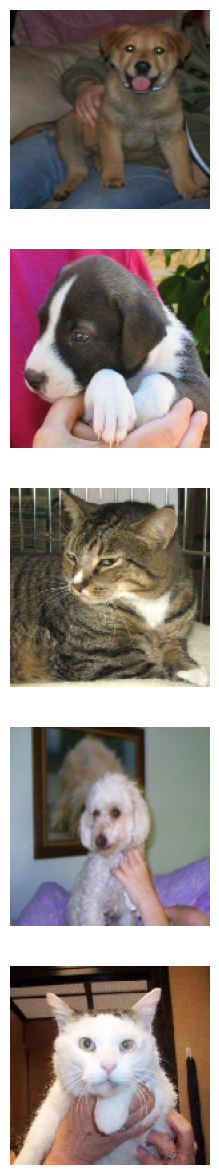

In [4]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
        for img, ax in zip( images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, ax in zip( images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if probability > 0.5:
                ax.set_title("%.2f" % (probability*100) + "% dog")
            else:
                ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [5]:
# data augmentation
train_image_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, zoom_range=0.2, shear_range=0.2, rotation_range=90)

Found 2000 images belonging to 2 classes.


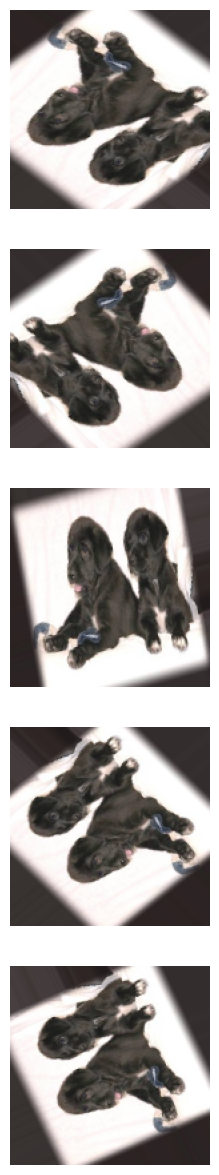

In [6]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

## Building CNN Model

Since the image data are loaded, we can use a convolutional neural network. Implementation steps are as follow:

1. We use 32 filters on a single 150px-150px image with (2,2) being a window size of a filter. The output is layers of secondary filters for that image. 

2. In each secondary filter, the values represent how well that previous first filter is matched to the certain pattern within each sections of the given image input. The greater the value is, the more similarity between the first filter and the certain sections of the image. 

3. "ReLu" activation function will convert all the negative values to zeros since we do not need to differentiate between any part that is not similar to any section of the image. This results in layers of filters, with each filter having the postive values and zeros.

4. Maxpooling layer will have a certain window, poolsize=(2,2) in here, with a stride value of 2 (default to pool size). It will iterate through the secondary layers of filters to output smaller-sized third layers of filters, which are similar to the secondary ones but smaller.

5. We can repeat this process arbitrarily as the model demands.

6. Flatten() layer will flatten the nodes of the last previous layer into one dimensional array.

7. There can be any number of hidden units connected to the flattened array.

8. The two output neurons, connected to hidden units, will choose whether this image is cat or dog.


The above steps are done for a single image. During training, the steps are repeated for all of the input images.

In [7]:
# building model
model = Sequential([
    Conv2D(32, (2,2), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(64, (2,2), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(128, (2,2), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(64, (2,2), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(32, (2,2), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation="relu"),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(2)
    ])

# compiling the model
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

C:\Users\ASUS\anaconda3\envs\fcc_machine_learning_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 149, 149, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 35, 35, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 32)            │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,170 (715.51 KB)

 Trainable params: 183,170 (715.51 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# training the model
history = model.fit(x=train_data_gen, 
                    steps_per_epoch=total_train//batch_size,  
                    epochs=epochs, 
                    validation_data=val_data_gen, 
                    validation_steps=total_val//batch_size)

Epoch 1/15


C:\Users\ASUS\anaconda3\envs\fcc_machine_learning_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4957 - loss: 0.6956 - val_accuracy: 0.5357 - val_loss: 0.6914
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 13s 997ms/step - accuracy: 0.5547 - loss: 0.6918

C:\Users\ASUS\anaconda3\envs\fcc_machine_learning_env\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5547 - loss: 0.6918 - val_accuracy: 0.5096 - val_loss: 0.6910
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5173 - loss: 0.6911 - val_accuracy: 0.6283 - val_loss: 0.6795
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5312 - loss: 0.6894 - val_accuracy: 0.6250 - val_loss: 0.6771
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5658 - loss: 0.6838 - val_accuracy: 0.5592 - val_loss: 0.6659
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4922 - loss: 0.6963 - val_accuracy: 0.6442 - val_loss: 0.6624
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5864 - loss: 0.6687 - val_accuracy: 0.5134 - val_loss: 0.6991
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5703 - loss: 0.6504 - val_accuracy: 0.5000 - val_loss: 0.6890
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5552 - loss: 0.6749 - val_accuracy: 0.6496 - val_loss: 0.6390

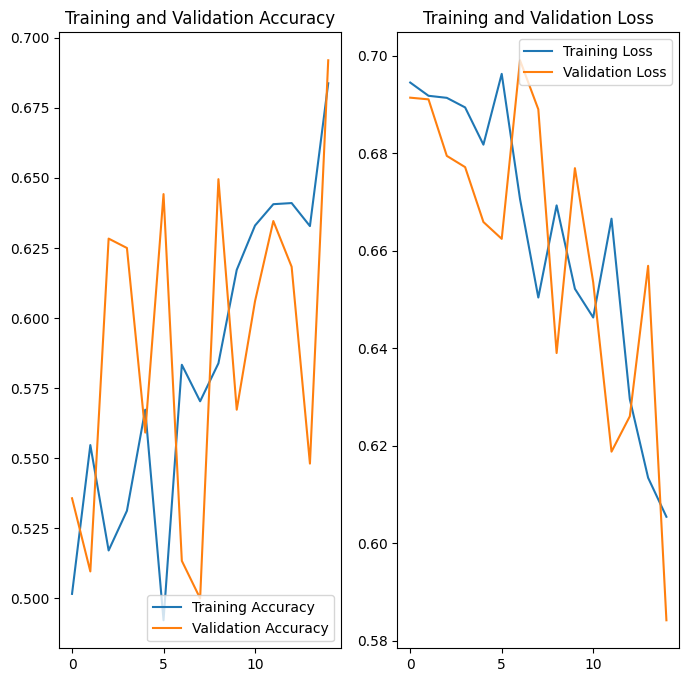

In [9]:
# plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


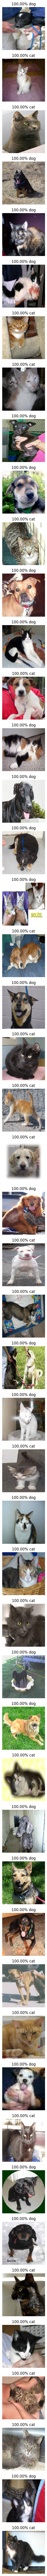

In [10]:
# the prediction output is a list of lists, each containing two weights for last dense(2) layer.
# argmax should include an axis parameter to return the index of the larger value of two weights 
# which are in each one of the lists within the list.
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)
plotImages(test_data_gen[0][0], probabilities=probabilities)

In [11]:
# checking results
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
    if round(probability) == answer:
        correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified * 100, 2)}% of the images of cats and dogs.")

if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!


# Note
1. using adam and SparseCategoricalCrossentropy
- 52% for dense(1) with activation relu, convos with no relu, loss output: nan
- 52% for dense(1) with activation relu, convos with activation relu, loss output: nan
- 52% for dense(1) with no relu, convos with activation relu, loss output: nan
- 52% for dense(2) with activation relu, convos with no relu, loss output: values
- 52% for dense(2) with activation relu, convos with activation relu, loss output: values
- 60% dense(2) with no relu, convos with activation relu, loss output: values <<< customize this
> should use dense(2) for adam

2. using RMSprop and BinaryCrossentropy
- 52% for dense(1) with activation relu, convos with no relu, loss output: values <<< customize this
- 52% for dense(1) with activation relu, convos with activation relu, loss output: values 
- 52% for dense(1) with no relu, convos with activation relu, loss output: values
- dense(2) - logits and labels must have the same shape 
> must use Dense(1) with RMSprop

3. customizations
- adding layers will slow down the slope (slowly learn)
- lower strides, more precision
- flatten() to dense() should be around 2000>>64
- adding relu to every layer controls the value growth